[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZiyuZhang1/computational-tools-for-DS/blob/master/Sentiment_Analysis_yaxin.ipynb)




## **Install Environment and Import Libraries**

In [1]:
!pip install datasketch
!pip install datasets
!pip install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from datasets import load_dataset
import nltk
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import gzip
import json
import os
import nltk
import string
from nltk import pos_tag # Part-of-Speech (POS) tagging
from nltk.stem import WordNetLemmatizer # lemmatize a word
from nltk.stem.porter import PorterStemmer # Information Retrieval
from nltk.tokenize import word_tokenize # splits sentence into words
from nltk.tokenize import WhitespaceTokenizer # splits on and discards only whitespace characters
from nltk.corpus import wordnet # large lexical database of English words
from nltk.sentiment.vader import SentimentIntensityAnalyzer # sentiment analyzer
from nltk.corpus import stopwords
import io
import time
import psutil
from sklearn.metrics import silhouette_score


## **Load data and preprocess**

In [3]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz

--2023-11-25 10:56:39--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53965563 (51M) [application/x-gzip]
Saving to: ‘Arts_Crafts_and_Sewing_5.json.gz’

Arts_Crafts_and_Sew 100%[===================>]  51.46M  15.1MB/s    in 3.6s    

2023-11-25 10:56:43 (14.5 MB/s) - ‘Arts_Crafts_and_Sewing_5.json.gz’ saved [53965563/53965563]



In [4]:
root = '/content/'
# dataset path
dataset_path = root + 'Arts_Crafts_and_Sewing_5.json.gz'

In [6]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [7]:
df = getDF(dataset_path)


In [9]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5.0,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4.0,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5.0,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5.0,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


In [10]:
df = df[['overall','reviewText']]


In [11]:
print(df.shape)

(494485, 2)


(array([ 14358.,      0.,  12784.,      0.,      0.,  28628.,      0.,
         61145.,      0., 377570.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

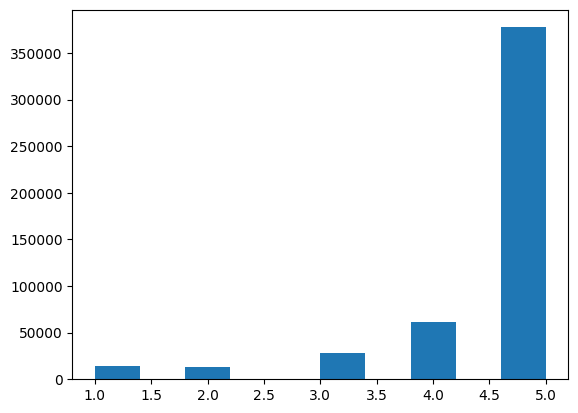

In [12]:
plt.hist(df['overall'])


In [13]:
##balance 5 levels
sample_size = df['overall'].value_counts().min()
groups = df.groupby('overall')
balance_idx = []
for key,subdf in groups:
    sample_idx = subdf.sample(n=sample_size).index
    balance_idx.extend(sample_idx)
balance_df = df.iloc[balance_idx]

In [14]:
balance_df.head(5)


,overall,reviewText
113009,1.0,I just received the Crayola Construction Paper...
327095,1.0,I got head aches even though it is orderless.
75128,1.0,prefer my dollar store glue stick. Dry and ha...


In [15]:
balance_df.isna().sum()


overall        0
reviewText    20
dtype: int64

In [16]:
balance_df.dropna(inplace=True)
balance_df.duplicated().sum()
balance_df.drop_duplicates(inplace=True)


<ipython-input-16-020f196d06b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df.dropna(inplace=True)
<ipython-input-16-020f196d06b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df.drop_duplicates(inplace=True)


In [17]:
# upload stopwords txt
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
english_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [18]:
# return the wordnet object value
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # remove \n
    text = text.replace('\n', '')
    # remove \t
    text = text.replace('\t', '')
    # remove ','
    text = text.replace(',', '')
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers and special characters
    text = [word for word in text if word.isalnum() and not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in english_stopwords]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return(text)

In [19]:
balance_df['Clean_Review'] = balance_df['reviewText'].apply(lambda x: clean_text(x))
balance_df.head()

<ipython-input-19-35d27795b480>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df['Clean_Review'] = balance_df['reviewText'].apply(lambda x: clean_text(x))


,overall,reviewText,Clean_Review
113009,1.0,I just received the Crayola Construction Paper...,receive crayola construction paper order amazo...
327095,1.0,I got head aches even though it is orderless.,get head ache even though orderless
75128,1.0,prefer my dollar store glue stick. Dry and ha...,prefer dollar store glue stick dry hard spread
475864,1.0,they broke trying to put them on wire,break try put wire
183669,1.0,"I feel frustrated , I ordered this cord to fit...",feel frustrate ordered cord fit singer sew mac...


In [20]:
# Convert the DataFrame to a CSV string
balance_df.to_csv(index=False)




Output hidden; open in https://colab.research.google.com to view.

In [21]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
balance_df['sentiment'] = [ map_sentiment(x) for x in balance_df['overall']]

<ipython-input-21-00eb0287acb3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_df['sentiment'] = [ map_sentiment(x) for x in balance_df['overall']]


In [23]:
df = balance_df.dropna()
reviews = df['Clean_Review']


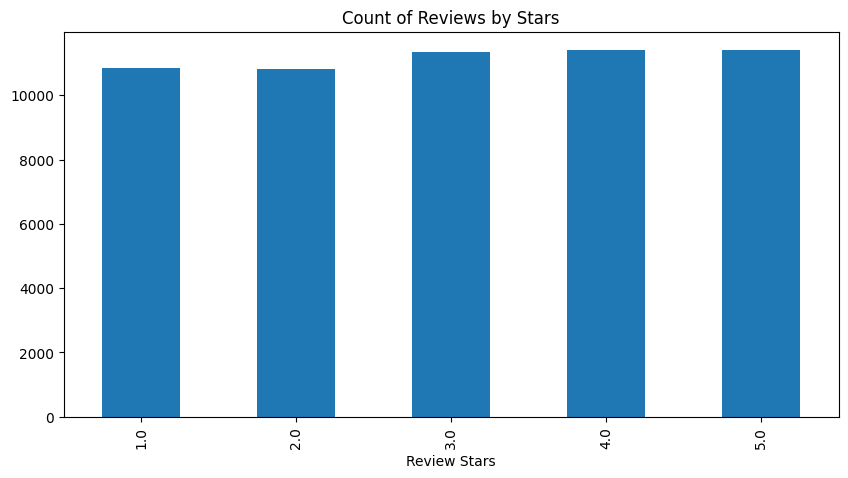

In [24]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',
                                               figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

# **Extracting embedding 2 methods: Word2Vec and Bert**

In [25]:
word2vec_model = Word2Vec(sentences=reviews, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
### Please use GPU for this part, otherwise it will be quite slow

# Ensure CUDA (GPU) is available and set as the default device, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def encode_sentences(sentences, max_length=512):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt',
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)

    return input_ids, attention_masks

# Function to process sentences in batches
def get_bert_embeddings(sentences, batch_size=128):
    all_embeddings = []

    for start_index in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[start_index:start_index+batch_size]
        input_ids, attention_masks = encode_sentences(batch_sentences)

        with torch.no_grad():
            # Move model to the same device as your data
            bert_model.to(device)

            outputs = bert_model(input_ids, attention_mask=attention_masks)
            batch_embeddings = outputs[0].mean(dim=1)  # Average pooling over the token dimension

            # Move embeddings to CPU for further processing or storage
            all_embeddings.append(batch_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

# Process all sentences and get embeddings
embeddings = get_bert_embeddings(reviews)
print(embeddings.shape)



Using device: cuda


100%|██████████| 437/437 [07:02<00:00,  1.04it/s]

torch.Size([55857, 768])


# **Three Clustering Algorithms**


## ***Clustering algorithms in our own code***

###Improved KMeans in our code

In [30]:
def kmeans_plusplus(X, k, max_iters=100, tol=1e-4):
    """
    K-means++ clustering algorithm.

    Parameters:
    - X: numpy array, shape (n_samples, n_features)
        The input data.
    - k: int
        Number of clusters.
    - max_iters: int, optional, default: 100
        Maximum number of iterations.
    - tol: float, optional, default: 1e-4
        Tolerance to declare convergence.

    Returns:
    - centroids: numpy array, shape (k, n_features)
        Final cluster centers.
    - labels: numpy array, shape (n_samples,)
        Index of the cluster each sample belongs to.
    - runtime: float
        Execution time in seconds.
    - cpu_percent: float
        Average CPU usage percentage.
    """

    start_time = time.time()

    # Randomly choose the first centroid
    centroids = [X[np.random.choice(X.shape[0])]]

    for _ in range(k - 1):
        # Compute distances from each data point to the nearest existing centroid
        distances = np.min(np.linalg.norm(X - np.array(centroids)[:, np.newaxis], axis=2), axis=0)

        # Choose the next centroid with probability proportional to distance squared
        probabilities = distances**2 / np.sum(distances**2)
        new_centroid = X[np.random.choice(X.shape[0], p=probabilities)]
        centroids.append(new_centroid)

    centroids = np.array(centroids)

    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    end_time = time.time()
    runtime = end_time - start_time

    # Calculate average CPU usage percentage during the algorithm execution
    cpu_percent = psutil.cpu_percent(interval=1)

    return centroids, labels, runtime, cpu_percent


### CURE in our own code

In [31]:
def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def hierarchical_clustering(data, n_clusters):
    """Perform simple hierarchical clustering to initialize centroids."""
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    return centroids

def select_representatives(data, centroids, n_representatives, shrink_factor):
    """Select and shrink representatives for each cluster."""
    representatives = {}
    for idx, centroid in enumerate(centroids):
        distances = np.array([euclidean_distance(point, centroid) for point in data])
        furthest_points = data[np.argsort(distances)[-n_representatives:]]
        representatives[idx] = centroid + shrink_factor * (furthest_points - centroid)
    return representatives

def assign_clusters(data, representatives):
    """Assign each data point to the nearest representative."""
    cluster_assignments = np.zeros(len(data))
    for i, point in enumerate(data):
        nearest_cluster = min(representatives.keys(), key=lambda k: euclidean_distance(point, np.mean(representatives[k], axis=0)))
        cluster_assignments[i] = nearest_cluster
    return cluster_assignments

def cure_clustering(data, n_clusters, n_representatives, shrink_factor):
    """CURE algorithm implementation."""
    centroids = hierarchical_clustering(data, n_clusters)
    representatives = select_representatives(data, centroids, n_representatives, shrink_factor)
    return assign_clusters(data, representatives)


# **Clustering Results**

##Word2Vec Clustering results

In [ ]:

### KMeans
kmeans = KMeans(n_clusters=num_clusters,init='k-means++', random_state=0)
# Fit the model
X_KMeans = word_vectors.vectors
KMeans_clusters = kmeans.fit(X_KMeans)
# Getting the cluster labels
KMeans_lables = kmeans.labels_
print("KMeans Cluster assignments:", KMeans_lables)
print(KMeans_lables.shape)

### DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)

X_DBSCAN = word_vectors.vectors
DBSCAN_clusters = dbscan.fit_predict(X_DBSCAN)
DBSCAN_lables = dbscan.labels_
# Output the cluster assignments
print("DBSCAN Cluster assignments:", DBSCAN_lables)

# ### CURE
# X_CURE = word_vectors.vectors
# n_clusters = 3
# n_representatives = 5
# shrink_factor = 0.5
# CURE_clusters = cure_clustering(X_CURE, n_clusters, n_representatives, shrink_factor)

# print("CURE Cluster assignments:", CURE_clusters)


NameError: ignored

##Bert Embeddings Clustering results

In [32]:
# averaged_embeddings = embeddings.mean(dim=0).detach().numpy()

# Define the number of clusters
num_clusters = 3

### KMeans
kmeans = KMeans(n_clusters=num_clusters,init='k-means++', random_state=0)
Bert_KMeans_clusters = kmeans.fit_predict(embeddings)
Bert_KMeans_lebles = kmeans.labels_
print("KMeans Cluster assignments using Bert Embeddings:", Bert_KMeans_lebles)
print(Bert_KMeans_lebles.shape)

### CURE
n_clusters = 3
n_representatives = 5
shrink_factor = 0.5
CURE_embeddings = embeddings.numpy()
Bert_CURE_clusters = cure_clustering(CURE_embeddings, n_clusters, n_representatives, shrink_factor)

print("CURE Cluster assignments using Bert Embeddings:", Bert_CURE_clusters)
print(Bert_CURE_clusters.shape)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Cluster assignments using Bert Embeddings: [1 0 2 ... 1 1 1]
(55857,)
CURE Cluster assignments using Bert Embeddings: [1. 0. 1. ... 1. 2. 2.]
(55857,)


In [36]:
print(len(Bert_KMeans_lebles))  # Number of cluster labels
print(df.shape[0])             # Number of rows in DataFrame

# Add the KMeans cluster labels to the DataFrame
df['cluster_label'] = Bert_KMeans_lebles
print(df['cluster_label'])
from sklearn.metrics.pairwise import euclidean_distances

def find_closest_sentences_to_centroids(embeddings, centroids, sentences):
    closest_sentences = []
    for centroid in centroids:
        distances = euclidean_distances([centroid], embeddings)
        closest_sentence_index = distances.argmin()
        closest_sentences.append(sentences[closest_sentence_index])
    return closest_sentences

# Assuming 'embeddings' is your array of sentence embeddings
# and 'df' is your DataFrame with the corresponding sentences
closest_sentences = find_closest_sentences_to_centroids(embeddings, kmeans.cluster_centers_, df['reviewText'].tolist())
for i, sentence in enumerate(closest_sentences):
    print(f"Closest sentence to centroid {i}: {sentence}")



55857
55857
113009    1
327095    0
75128     2
475864    1
183669    1
         ..
193724    0
404952    0
69886     1
54871     1
156092    1
Name: cluster_label, Length: 55857, dtype: int32
Closest sentence to centroid 0: Good price on this ruler and it works well.  Can't wait to save up for more Omnigrip accessories.
Closest sentence to centroid 1: I received my Cricut for a Christmas gift 2 yrs ago and have tried using it several times since then for many things and I just don't care for it. You have to use fairly thin or lightweight cardstock to get it to cut all the way through and lift crisp and cleanly from the sticky paper, even after increasing the depth of the cutter blade, etc. I keep going back to it thinking that the more I play with it and get used to it, the more I'll like it. It's just not happening and it just sits in the corner of my craft room, unused. I'm going to try to sell it. It's a shame, too, because I have 6 cartridges to go with it. I really like my other 

# **Visualize clustering results**

Wor2Vec Embeddings

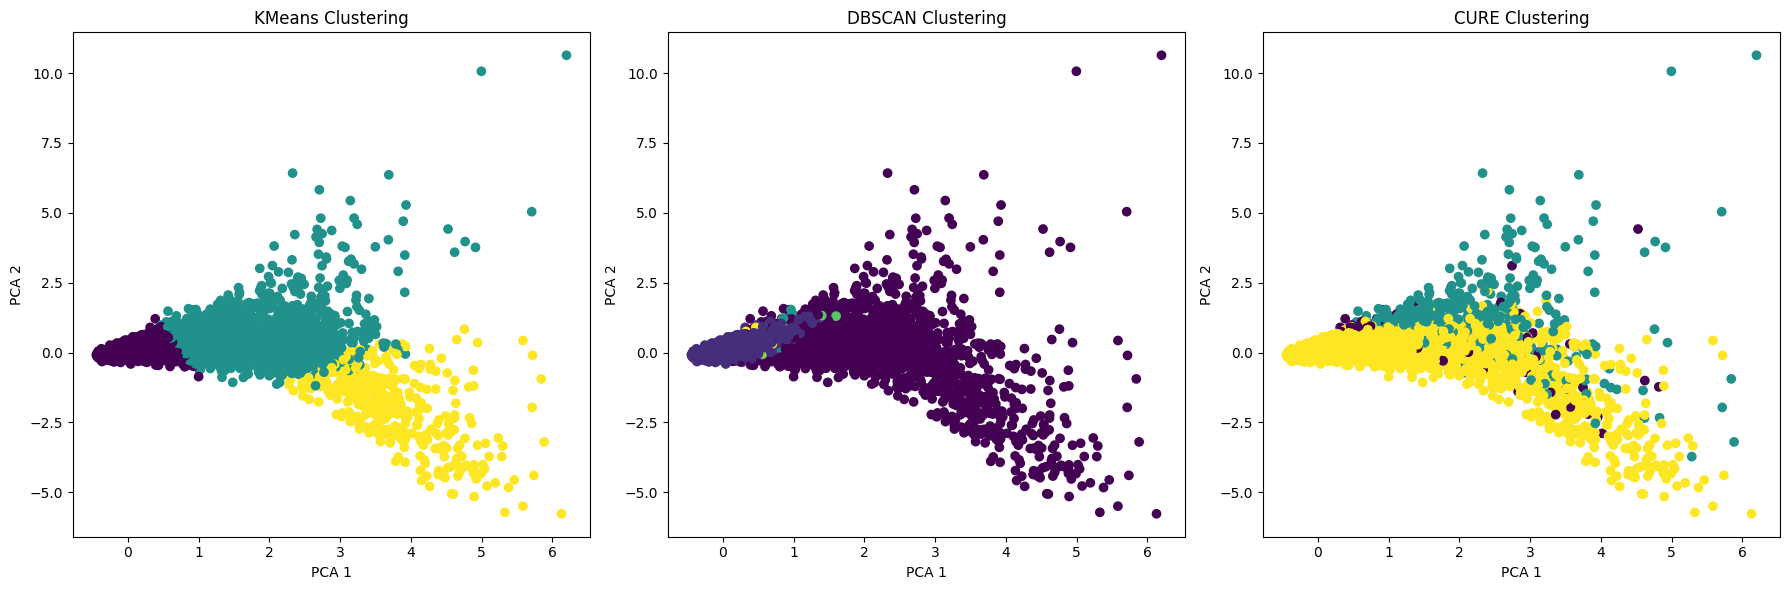

In [ ]:
# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(X_KMeans)  # Assuming X_KMeans, X_DBSCAN, X_CURE are similar

# Creating a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting KMeans results
axes[0].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=KMeans_lables, cmap='viridis')
axes[0].set_title('KMeans Clustering')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

# Plotting DBSCAN results
axes[1].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=DBSCAN_lables, cmap='viridis')
axes[1].set_title('DBSCAN Clustering')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')

# Plotting CURE results
# Assuming CURE_clusters contains the cluster labels
axes[2].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=CURE_clusters, cmap='viridis')
axes[2].set_title('CURE Clustering')
axes[2].set_xlabel('PCA 1')
axes[2].set_ylabel('PCA 2')

plt.tight_layout()
plt.show()


Bert Embeddings

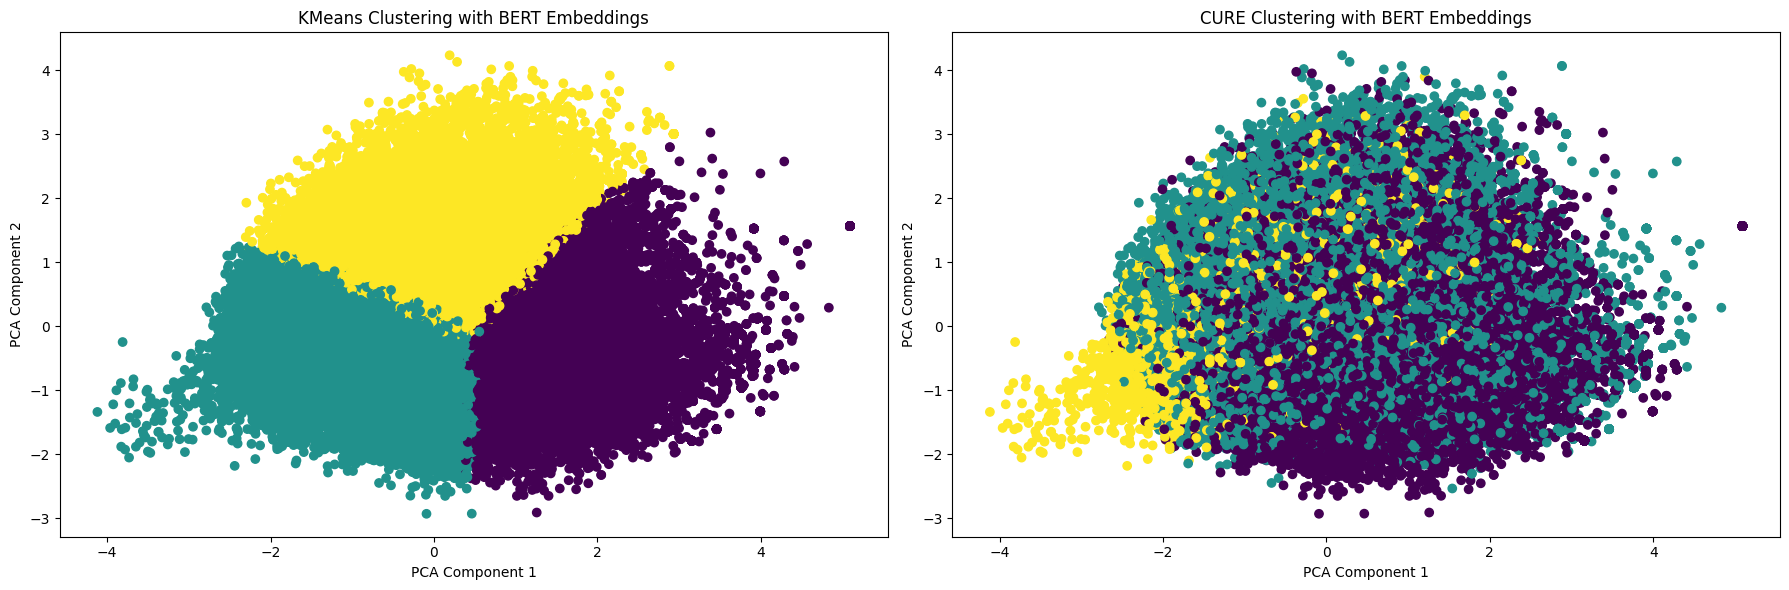

In [38]:
# PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Creating a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting KMeans results
axes[0].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=Bert_KMeans_lebles, cmap='viridis')
axes[0].set_title('KMeans Clustering with BERT Embeddings')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Plotting CURE results
axes[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=Bert_CURE_clusters, cmap='viridis')
axes[1].set_title('CURE Clustering with BERT Embeddings')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()




# **Map clusters to sentiment labels**

# **Evaluate Methods using test dataset**

In [56]:
dataset = load_dataset("financial_phrasebank","sentences_50agree")
full_data = dataset['train']

In [63]:
# from datasets import load_dataset

# dataset = load_dataset("financial_phrasebank","sentences_50agree")
# full_data = dataset['train']

# Calculate the number of samples for 10%
sample_size = int(0.01 * len(full_data))

# Random sampling 10% of the data
sample_data = full_data.shuffle(seed=99).select(range(sample_size))
test_data_df = pd.DataFrame(sample_data['sentence'], columns=['sentence'])
test_data_df['tokenized_text'] = test_data_df['sentence'].apply(lambda x: nltk.word_tokenize(str(x)))
test_texts = test_data_df['tokenized_text']
# Fit k-means clustering on the embeddings
# Ensure the embeddings are converted to float32 before fitting
test_embeddings = get_bert_embeddings(test_texts, batch_size=32).numpy().astype('float32')
kmeans.fit(test_embeddings)

# Now make sure to convert embeddings to float32 when predicting as well
def predict_cluster(sentences, kmeans_model, batch_size=128):
    test_embeddings = get_bert_embeddings(sentences, batch_size).numpy().astype('float32')
    closest_clusters = kmeans_model.predict(test_embeddings)
    return closest_clusters

# Your test_data['sentence'] should then be processed with the predict_cluster function
closest_clusters = predict_cluster(test_texts.tolist(), kmeans, batch_size=32)

# Add the cluster predictions to your test DataFrame
test_data_df['predicted_cluster'] = closest_clusters
# def switch_labels(label):
#     if label == 0:
#         return 2
#     elif label == 2:
#         return 0
#     else:
#         return label

# # Apply the function to switch labels
# test_data['switched_predicted_cluster'] = test_data['predicted_cluster'].apply(switch_labels)

# Now, test_data has a new column 'switched_predicted_cluster' with the switched labels


# Compute accuracy
accuracy = (sample_data['label'] == test_data_df['predicted_cluster']).mean()
print(f"Accuracy: {accuracy}")


100%|██████████| 2/2 [00:00<00:00,  5.15it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

Accuracy: 0.22916666666666666
